In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [37]:
IMAGE_SIZE = 256 # size of each image
BATCH_SIZE = 32 # no. of images in each batch
CHANNELS = 3 # rgb channels
EPOCHS = 10

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="PlantVillage_tomato", 
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 11704 files belonging to 10 classes.


In [10]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites',
 'Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'Tomato_mosaic_virus']

In [40]:
len(dataset)# 366 because 11704 images are divided in batch of size 40 each thus total 11704/32 = 366 batches
# last batch may not have 32 images becoz 11704/32 = 365.75

366

In [41]:
for image_batch, label_batch in dataset.take(1): # it gives one batch with 32 images
    print(image_batch.shape) # (images(32), size(256,256), rgb(3))
    print(label_batch.numpy()) #(10 classes(0,1,2,3,4,5,6,7,8,9) for ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites','Tomato_YellowLeaf__Curl_Virus','Tomato__Target_Spot','Tomato_healthy','Tomato_mosaic_virus'])

(32, 256, 256, 3)
[9 5 6 0 0 0 0 6 0 1 0 4 3 4 2 8 8 6 8 6 1 1 7 0 7 8 6 1 2 0 0 5]


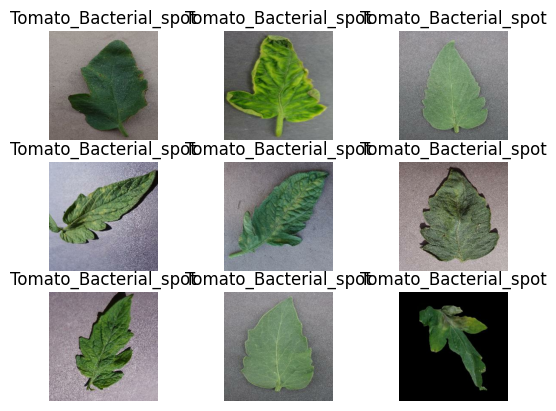

In [42]:
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        # print(image_batch[i].shape)
        plt.imshow(image_batch[i].numpy().astype("int"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [43]:
# Train Test Split 
# 80% -> training
# 20% -> 10% validation, 10% testing

# we have 366 batches, 80% of 366 is around 292, thus we use 292 batches data for train
# validation data is 36 batches 
# test data is 38 batches
train_size = 0.8
len(dataset)*train_size

292.8

In [44]:
# writing a function for above train test split task 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(val_ds), len(test_ds)

(292, 36, 38)

In [46]:
# we will do caching and prefetch
# it will read the image from the disk and then for the next iteration when you need the same image it will keep the image in the memory(RAM)
# also the next batch will be processed without wasting time
# watch this for more - https://www.youtube.com/watch?v=MLEKEplgCas&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=45

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# now these datasets are optimizrd for training, and will train fast 

In [47]:
# Scaling the dataset

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# all our images are 256x256 but still we are doing resizing becoz this resize_and_rescale image will eventually go to aur model.
# and when we start predicting from model and give any image that is not 256x256 this layer will take care of it and resize it first.

In [48]:
# Data Agumentation
# we add flipped, rotated, Zoomed, Contrasted etc images in dataset to make model more robust for pridiction

data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)
])

In [52]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model_tomato = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model_tomato.build(input_shape=input_shape)

c:\Users\utkarsh.alpuria\Desktop\My Work\Python\Python ML\Potato_Disease_1-main\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model_tomato.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model_tomato.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [55]:
model_tomato.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.2226 - loss: 2.0918 - val_accuracy: 0.3750 - val_loss: 1.7687
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.4818 - loss: 1.4180 - val_accuracy: 0.5166 - val_loss: 1.3202
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.6429 - loss: 1.0148 - val_accuracy: 0.6696 - val_loss: 0.9488
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7493 - loss: 0.7163 - val_accuracy: 0.6914 - val_loss: 0.9044
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.7914 - loss: 0.5956 - val_accuracy: 0.7010 - val_loss: 0.8307
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.8121 - loss: 0.5447 - val_accuracy: 0.7194 - val_loss: 0.7522
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8370 - loss: 0.4630 - val_accuracy: 0.8112 - val_loss: 0.5401
Epoch 8/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.8610 - loss: 0.3926 - val_accu

In [56]:
scores = model_tomato.evaluate(test_ds)

38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 350ms/step - accuracy: 0.8730 - loss: 0.3830


In [57]:
scores

[0.3428671956062317, 0.8824012875556946]

In [76]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


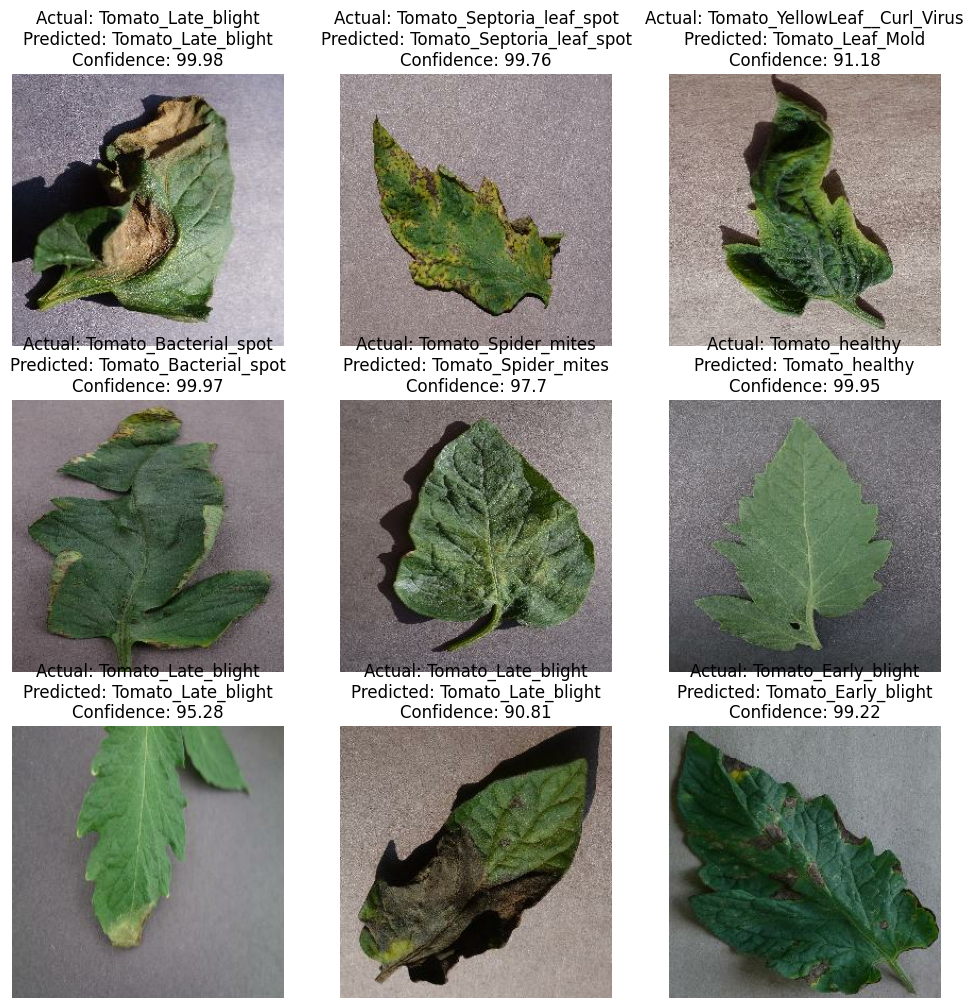

In [77]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("int"))

        predicted_class, confidence = predict(model_tomato, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}")
        plt.axis("off")

In [74]:
model_version=1

model_tomato.save(f"../Models/tomato_model_{model_version}.keras")

# to load saved model use: 
# model = keras.models.load_model("path")